Reading scores from D:\data\eegemotion\score-P\ShotScore-P001-zhanghao2020-12-28-11-23-15-2315.csv
Index(['leftEyeTargetPosition', 'rightEyeTargetPosition',
       'averageEyeTargetPosition', 'time', 'markerText'],
      dtype='object')
Reading from D:\data\eegemotion\preprocess2\eeg-P_fif\eeg2h5\P001_zhanghao_2020-12-28_10-47-29.h5
Opening raw data file D:\data\eegemotion\preprocess2\eeg-P_fif\P001_zhanghao_2020-12-28_10-47-29.fif...
Isotrak not found
    Range : 0 ... 2162818 =      0.000 ...  2162.818 secs
Ready.
yes
Used Annotations descriptions: ['Marker/Impedance', 'New Segment/', 'Stimulus/s1001', 'Stimulus/s1002', 'Stimulus/s1003', 'Stimulus/s1004']
Not setting metadata
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
98 matching events found
Setting baseline interval to [-3.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 98 events and 3001 original 

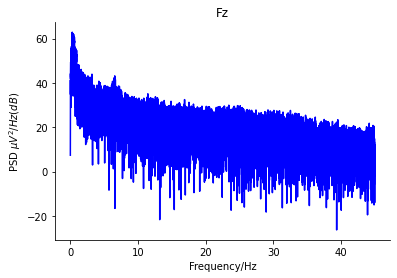

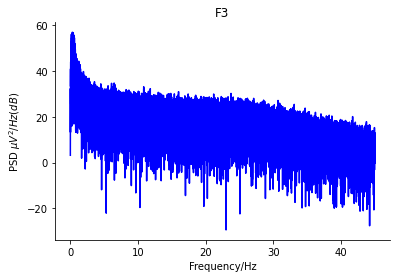

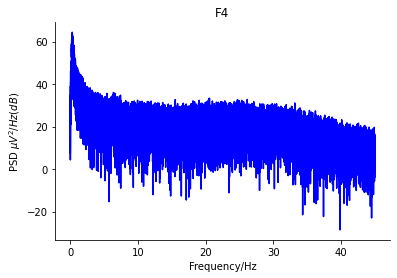

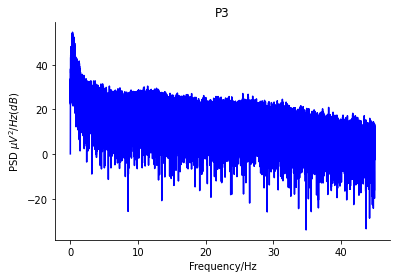

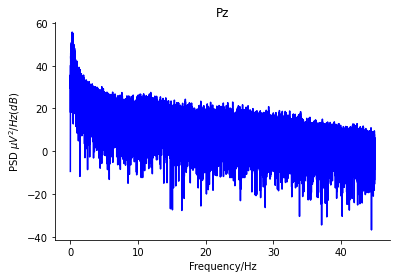

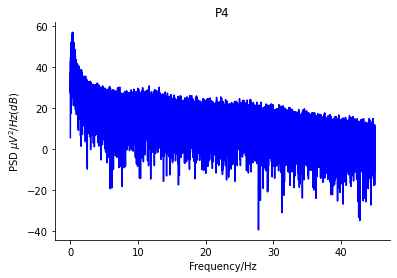

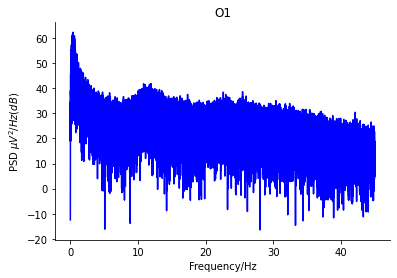

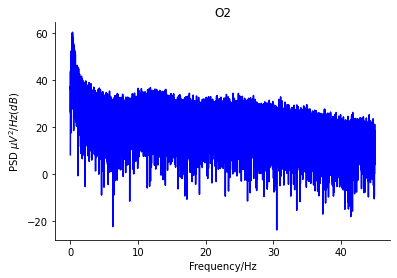

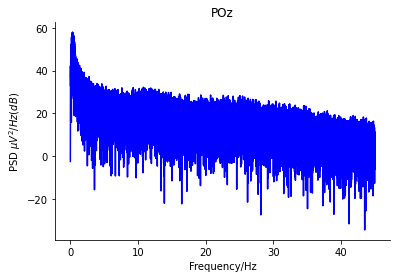

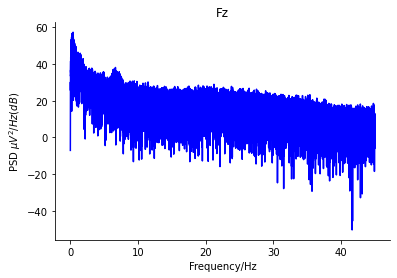

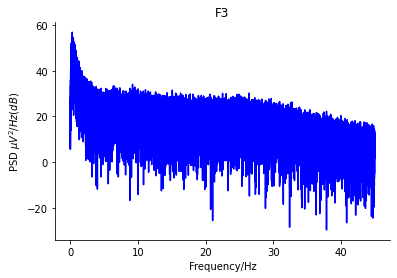

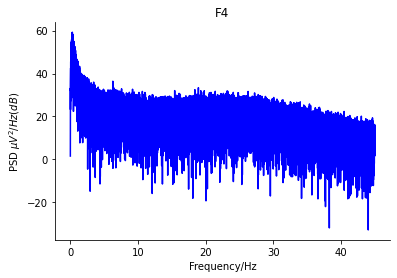

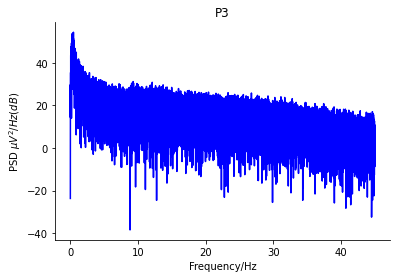

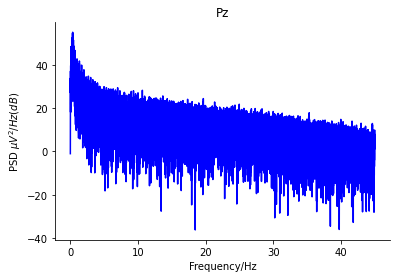

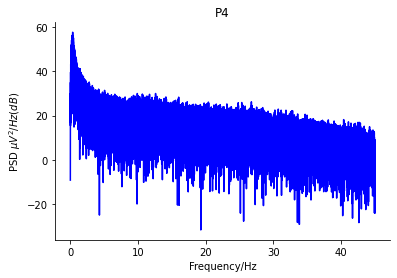

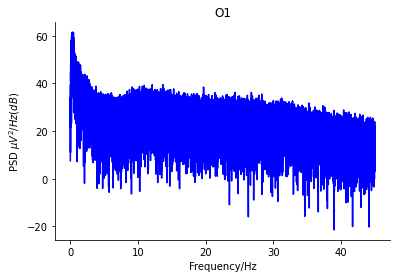

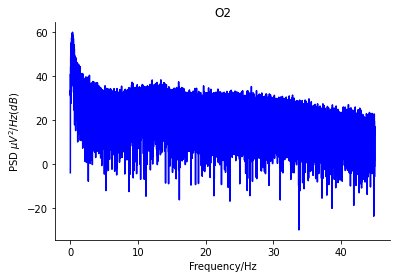

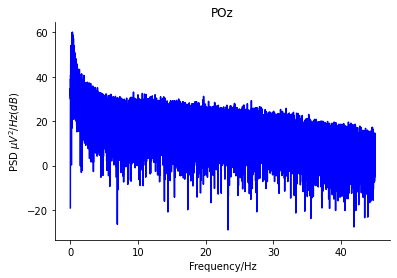

In [1]:
from score import get_score
from state import get_state
import matplotlib.pyplot as plt
import traceback
import mne
import numpy as np
import pandas as pd
from spectrum import Periodogram, TimeSeries
from eegprocess import get_raw_eeg,get_epoch_eeg
 
        
def plot_channel_psd(data_eeg,channel):
    def get_band(data,chname):
        p=Periodogram(data,sampling=1000)
        p.run()
        frepsd=pd.DataFrame()
        frepsd["freq"]=p.frequencies()
        frepsd["psd"]=10*np.log10(p.psd)
        frepsd.drop(frepsd[frepsd["freq"]>=45].index,inplace=True)

        fig = plt.figure(1)
        ax = plt.axes()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.plot(frepsd["freq"].tolist(),frepsd["psd"].tolist(),color="blue")
        plt.xlabel("Frequency/Hz")
        plt.ylabel("PSD $\mu V^2/Hz (dB)$")
        plt.title(chname)
        plt.show()
    get_band(data_eeg.to_data_frame()[channel].tolist(),channel)


highscore_epoch,lowscore_epoch=None,None
highscorenum,lowscorenum=0,0
for i in range(1,60):
    try:
        data_score=get_score(i)[0]
        data_state=get_state(i,3)
        data_eeg=get_epoch_eeg(i).drop(["condition"],axis=1)
        data_raw_eeg=get_raw_eeg(i)
        if not (len(data_score)==len(data_eeg["epoch"].value_counts()) and len(data_score)==len(data_state[data_state["markerText"]=="ShotOps"])): continue
        print("yes")
        events,event_id=mne.events_from_annotations(data_raw_eeg)
        epochs=mne.Epochs(data_raw_eeg,events,event_id,tmin=-3,tmax=0,event_repeated='drop',preload=True)
        first,second=get_score(i+1)
        rest_eeg=epochs["s1001"][0]
        total_shot_num=len(first)+len(second)
        first_shoot_eeg=epochs["s1002"][-total_shot_num:-len(second)]
        for j in range(len(data_score)):
            if data_score[j]>9:
                if highscore_epoch==None:
                    highscore_epoch=first_shoot_eeg["s1002"][j]
                else:
                    highscore_epoch=mne.concatenate_epochs([highscore_epoch,first_shoot_eeg["s1002"][j]])
                highscorenum+=1

            if data_score[j]<8:
                if lowscore_epoch==None:
                    lowscore_epoch=first_shoot_eeg["s1002"][j]
                else:
                    lowscore_epoch=mne.concatenate_epochs([lowscore_epoch,first_shoot_eeg["s1002"][j]])
                lowscorenum+=1
        print(highscorenum)
        print(lowscorenum)
    except Exception as e:
        traceback.print_exc()
channelnames=["Fz","F3","F4","P3","Pz","P4","O1","O2","POz"]
print("test")

In [62]:
def get_psd_feature(data_eeg,channel,ifhigh,save_path):
    
    #highscore_epoch,lowscore_epoch
    def get_band(data,chname):
        freq_low=[0,4,8,12,30]
        freq_high=[4,8,12,30,45]
        p=Periodogram(data,sampling=1000)
        p.run()
        frepsd=pd.DataFrame()
        frepsd["freq"]=p.frequencies()
        frepsd["psd"]=10*np.log10(p.psd)
        frepsd.drop(frepsd[frepsd["freq"]>=45].index,inplace=True)
        bandmin,bandmax,bandmean=[],[],[]
        for i in range(len(freq_low)):
            cur_frepsd=frepsd[frepsd["freq"]>=freq_low[i]][frepsd["freq"]<=freq_high[i]]
            band_min=cur_frepsd["psd"].min()
            band_max=cur_frepsd["psd"].max()
            band_mean=cur_frepsd["psd"].mean()
            #print(band_min,band_max,band_mean)
            bandmin.append(band_min)
            bandmax.append(band_max)
            bandmean.append(band_mean)
        
        bar_width=0.3
        x=np.arange(5)
        tick_label=["Delta","Theta","Alpha","Beta","Gamma"]
        plt.bar(x,bandmin,bar_width,label="min",align="center")
        plt.bar(x+bar_width,bandmax,bar_width,label="max",align="center")
        plt.bar(x+bar_width*2,bandmean,bar_width,label="mean",align="center")
        plt.ylabel("PSD $\mu V^2/Hz (dB)$")
        plt.legend()
        plt.xticks(x+bar_width/2*3,tick_label)
        plt.title(ifhigh+"_"+channel)
        plt.savefig(os.path.join(save_path,ifhigh+"_"+channel+".jpg"))
        plt.close()
        #print(bandmin,bandmax,bandmean)
    get_band(data_eeg.to_data_frame()[channel].tolist(),channel)

In [63]:
for channelname in channelnames:
    get_psd_feature(highscore_epoch,channelname,"highscore",r"C:\Users\zhou\Desktop\毕业设计\mechanical\最终论文\pic\diff\psd")

In [64]:
for channelname in channelnames:
    get_psd_feature(lowscore_epoch,channelname,"lowscore"),r"C:\Users\zhou\Desktop\毕业设计\mechanical\最终论文\pic\diff\psd"